In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import pickle
import random
import gc
import lzma
import glob

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
from astropy.time import Time
import json

sys.path.append('..')
from env_config import PROJECT_PATH, DATA_PATH, STORAGE_PATH
from utils import pretty_print, read_fits_to_pandas
from light_curves import get_data_stats, add_lc_stats, preprocess_ztf_light_curves
from plotting import plot_light_curves
from ml import get_train_data, get_train_matrices
from ztf import ZTF_DATES
from features import FEATURES_DICT

/home/sjnakoneczny/tools/anaconda3/envs/py39-ztf/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/sjnakoneczny/workspace/ztf-agn/notebooks/../light_curves.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.dpi'] = 100
sns.set_style('ticks', {'axes.grid': False})
pd.set_option('mode.chained_assignment', None)
%matplotlib inline

/tmp/ipykernel_170062/781861970.py:2: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('retina')


In [4]:
ztf_date = ZTF_DATES['DR 20']

# Data

## Make a test fields subset

In [4]:
# Make a 1% subsample of the inference data
p_data = 0.01

In [5]:
fields = [296, 297, 423, 424, 487, 488, 562, 563, 682, 683, 699, 700, 717, 718, 777, 778, 841, 842, 852, 853]

inference_data = {'g': [], 'r': []}
for filter in ['g', 'r']:
    for field in tqdm(fields):
        with open(os.path.join(DATA_PATH, 'ZTF/ZTF_20240117/fields/ZTF_20240117__field_{}__{}-band'.format(field, filter)), 'rb') as file:
            data = pickle.load(file)
            n_obj = len(data)
            data = [data[i] for i in sorted(random.sample(range(n_obj), int(n_obj * 0.01)))]
            inference_data[filter].extend(data)
            gc.collect()

  0%|          | 0/20 [00:00<?, ?it/s]

In [6]:
# Save the random subsets
for filter in ['g', 'r']:
    with open(os.path.join(DATA_PATH, 'ZTF/ZTF_20240117/ZTF_20240117__test_fields_{}p__{}-band'.format(p_data * 100, filter)), 'wb') as file:
        pickle.dump(inference_data[filter], file)

In [7]:
# Load the random subsets
inference_data = {}
for filter in ['g', 'r']:
    with open(os.path.join(DATA_PATH, 'ZTF/ZTF_20240117/ZTF_20240117__test_fields_{}p__{}-band'.format(p_data * 100, filter)), 'rb') as file:
        inference_data[filter] = pickle.load(file)

In [12]:
# Remove deep drilling and get n_obs > 20
for filter in ['g', 'r']:
    inference_data[filter] = preprocess_ztf_light_curves(inference_data[filter])

Preprocessing input data size: 359353
Deep drilling and n_obs > 20: 204445 (56.89%)


In [13]:
# Save reduced
for filter in ['g', 'r']:
    with open(os.path.join(DATA_PATH, 'ZTF/ZTF_20240117__test_fields_1p__{}-band__reduced'.format(filter)), 'wb') as file:
        pickle.dump(inference_data[filter], file)

## Load data

In [6]:
filters = ['g', 'r']

### With lightcurves

In [6]:
# Get the training data
ztf_x_sdss_lc, sdss_x_ztf = {}, {}
for filter in filters:
    ztf_x_sdss_lc[filter], sdss_x_ztf[filter] = get_train_data(ztf_date=ztf_date, filter=filter)

In [6]:
# Load the reduced inference data
inference_data = {}
for filter in filters:
    with open(os.path.join(DATA_PATH, 'ZTF/ZTF_{}__test_fields_1p__{}-band__reduced'.format(ztf_date, filter)), 'rb') as file:
        inference_data[filter] = pickle.load(file)

In [8]:
# Add the statistics of interest
for filter in filters:
    inference_data[filter] = add_lc_stats(inference_data[filter])
    ztf_x_sdss_lc[filter] = add_lc_stats(ztf_x_sdss_lc[filter])

Adding light curve statistics:   0%|          | 0/204291 [00:00<?, ?it/s]

Adding light curve statistics:   0%|          | 0/2588221 [00:00<?, ?it/s]

Adding light curve statistics:   0%|          | 0/204445 [00:00<?, ?it/s]

Adding light curve statistics:   0%|          | 0/3750935 [00:00<?, ?it/s]

### With the pre calculated stats

In [7]:
# Read the train data
data = {}
for filter in filters:
    _, data[filter] = \
        get_train_data(ztf_date=ztf_date, filter=filter, return_light_curves=False)

In [8]:
# Add lightcurve stats
for filter in filters:
    file_name = 'ZTF_x_SDSS/ZTF_{}/ztf_{}_x_specObj-dr18__longests_filter_{}_reduced__stats'.format(
        ztf_date, ztf_date, filter)
    path = os.path.join(DATA_PATH, file_name)
    with open(path, 'rb') as file:
        df = pickle.load(file)
        data[filter] = pd.concat([data[filter], df], axis=1)

# Paper stats

In [9]:
for filter in filters:
    print(filter)
    y = data[filter]['CLASS']
    vals, counts = np.unique(y, return_counts=True)
    s = np.sum(counts)
    for val in counts:
        print(val / s * 100)

g
46.555491204190055
24.92298764286357
28.521521152946367
r
59.195560573563654
18.76025577622646
22.04418365020988


In [13]:
for filter in filters:
    print(filter)
    s = data[filter].shape[0]
    for survey in ['PS', 'WISE', 'GAIA']:
        features = FEATURES_DICT[survey]
        left = data[filter].dropna(subset=features).shape[0]
        print(survey, '\t', left / s * 100)

g
PS 	 97.57536160938344
WISE 	 77.18757401319284
GAIA 	 44.50524124485506
r
PS 	 83.2651858803205
WISE 	 79.11427417430588
GAIA 	 32.75162059593141


# Paper plots

## Coverage analysis

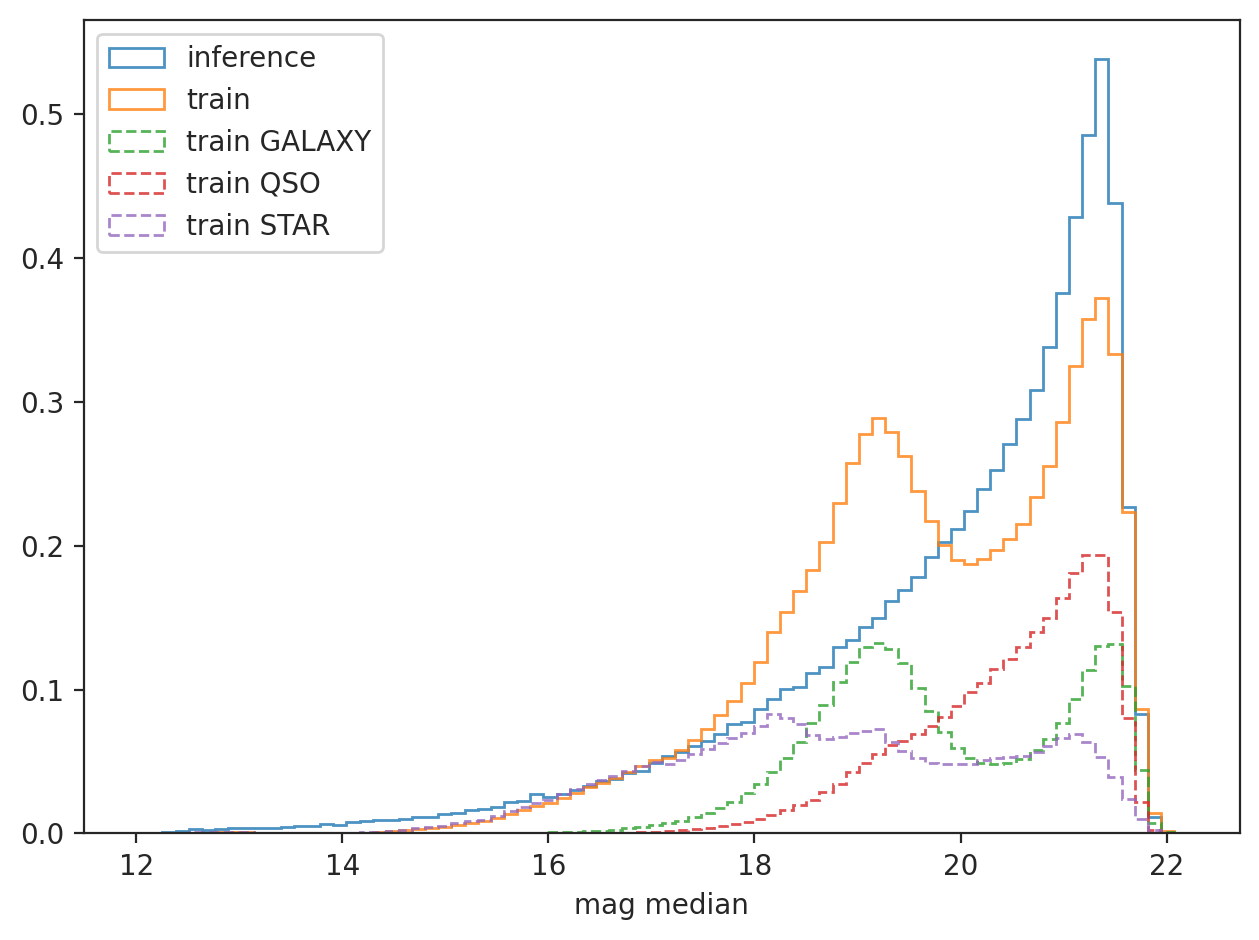

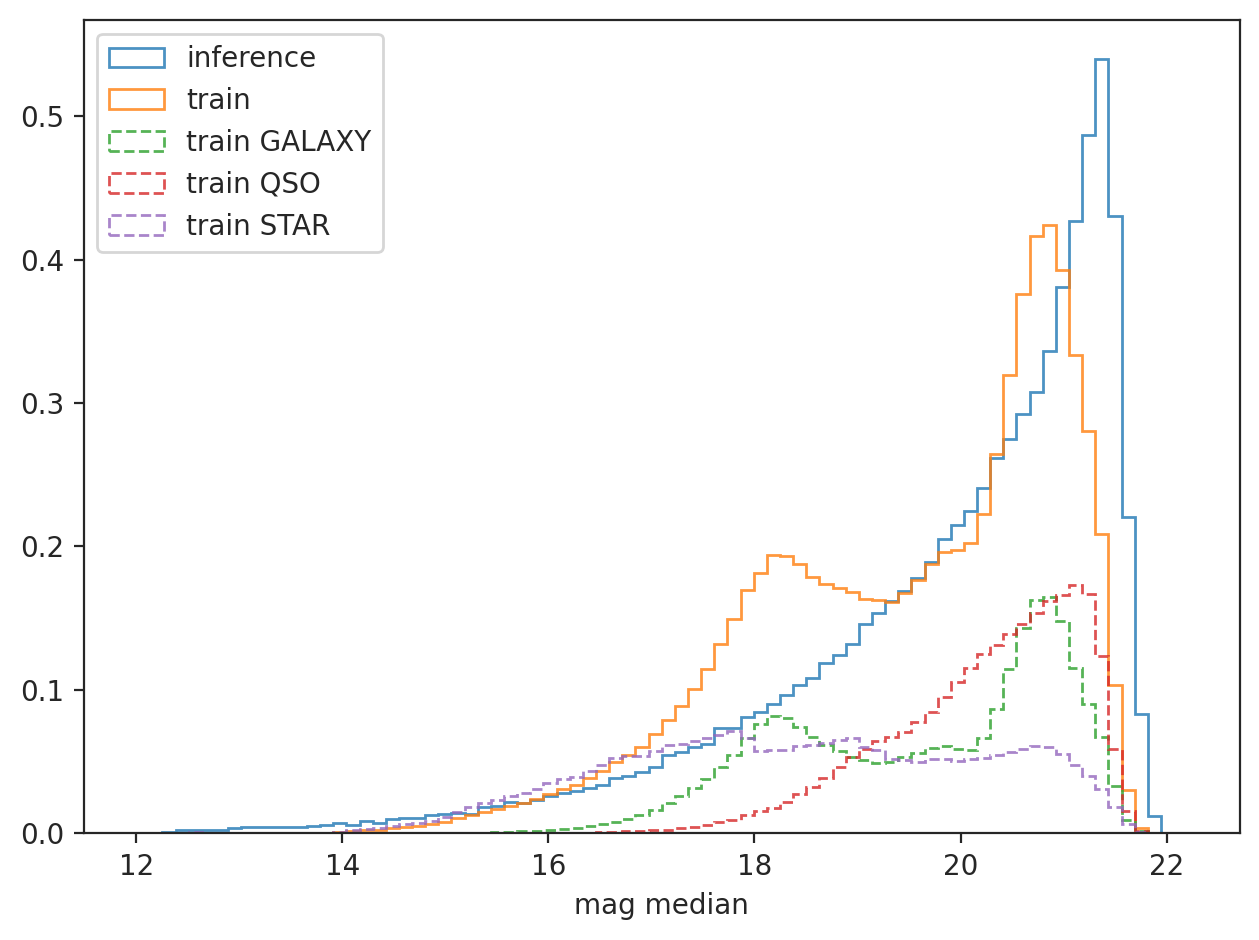

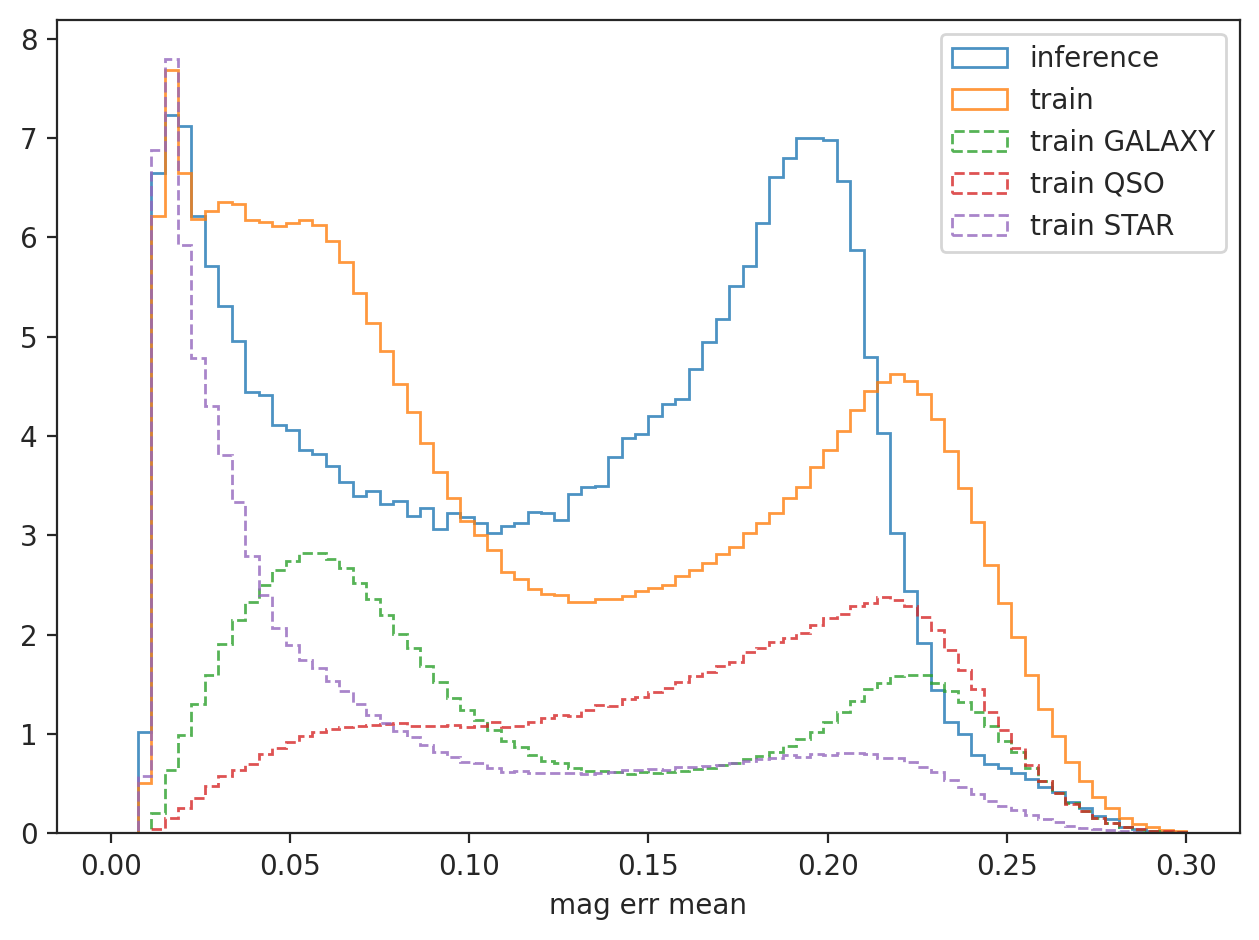

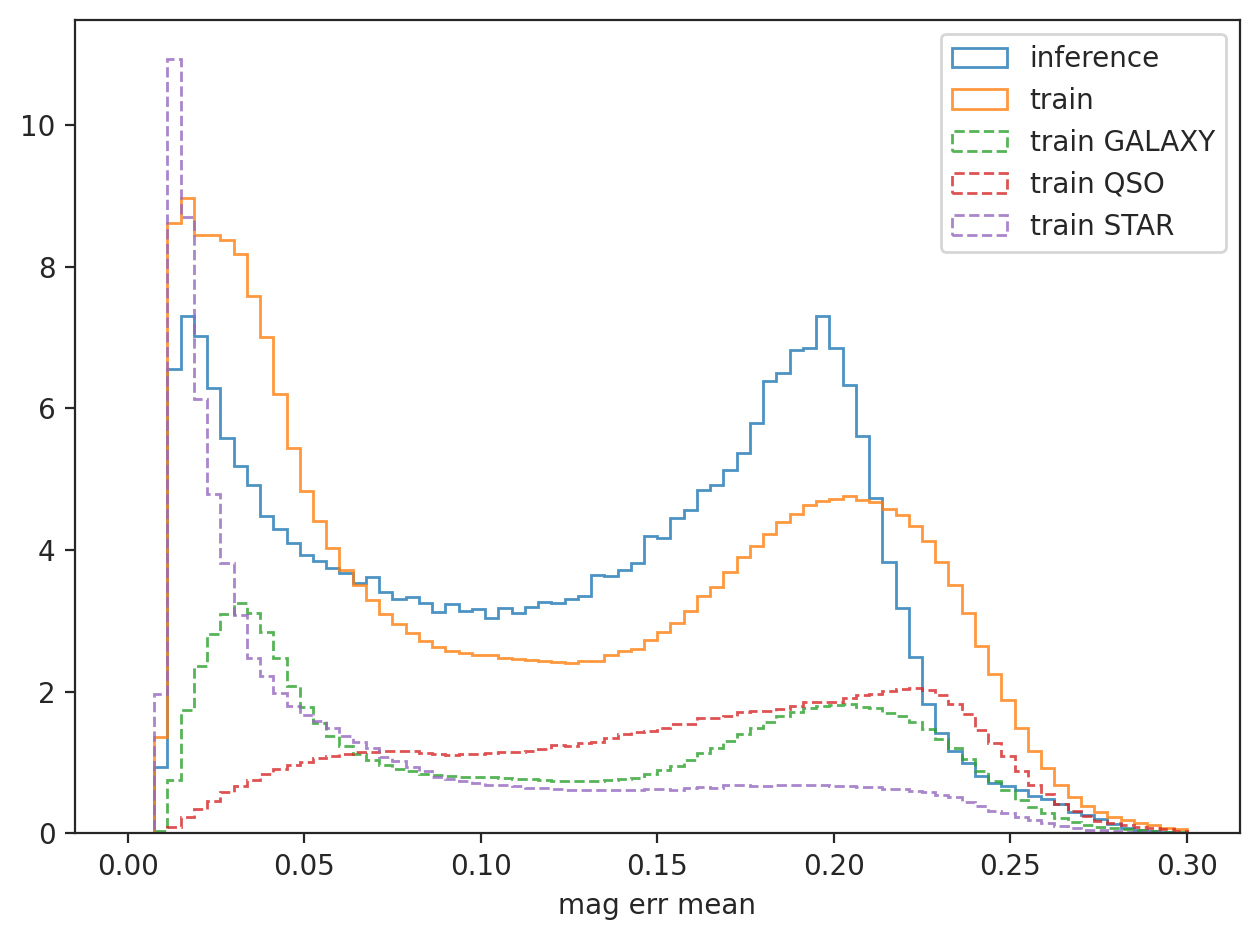

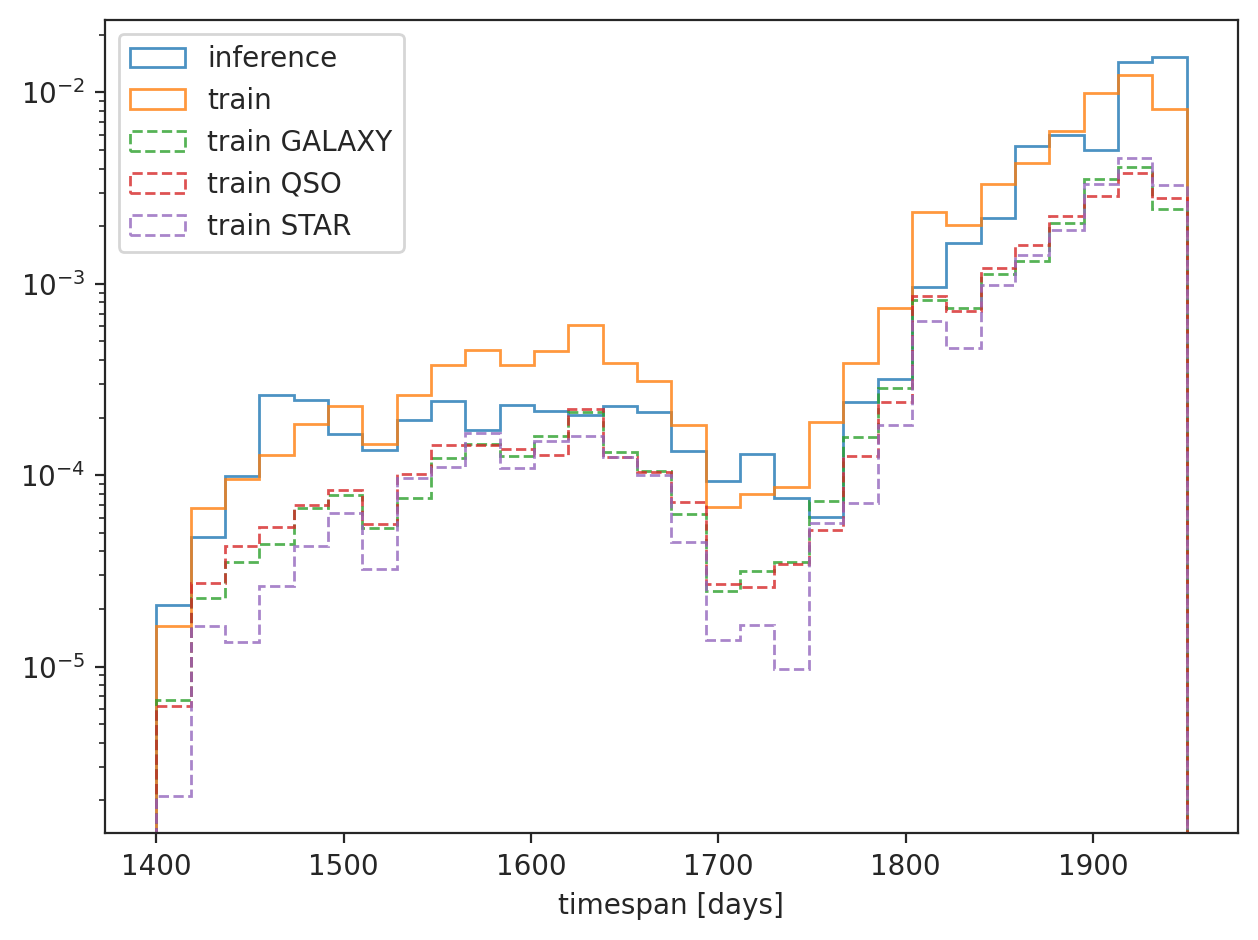

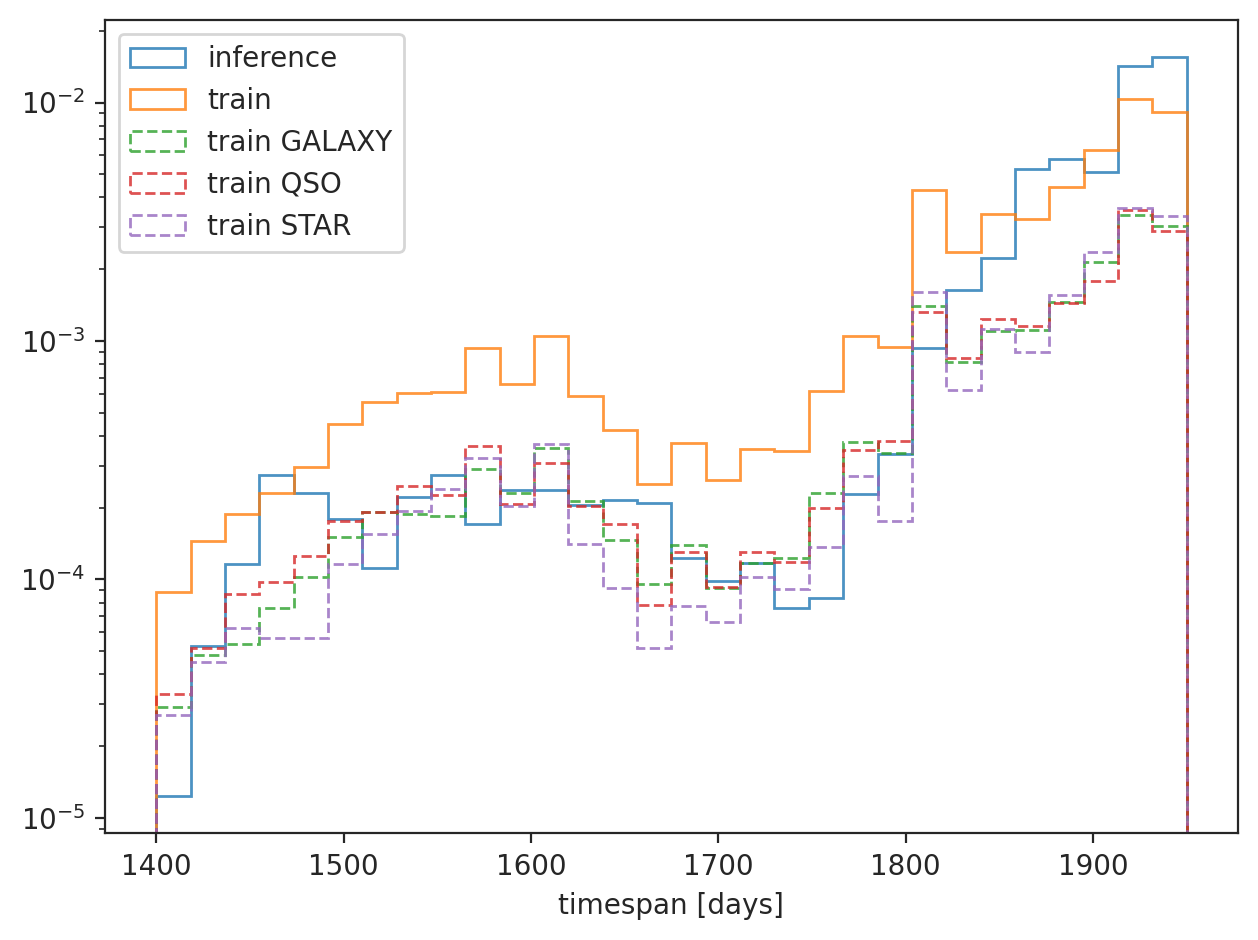

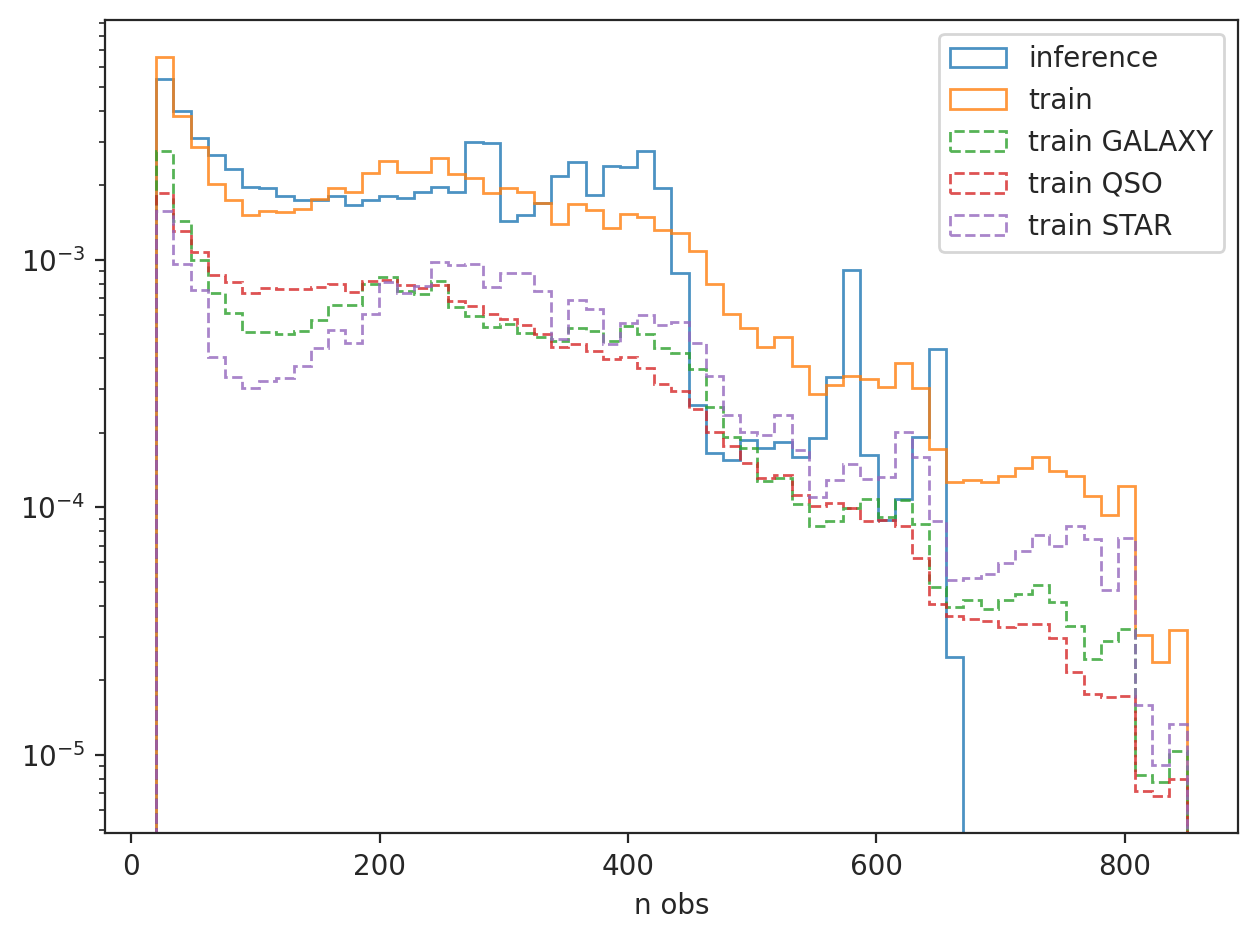

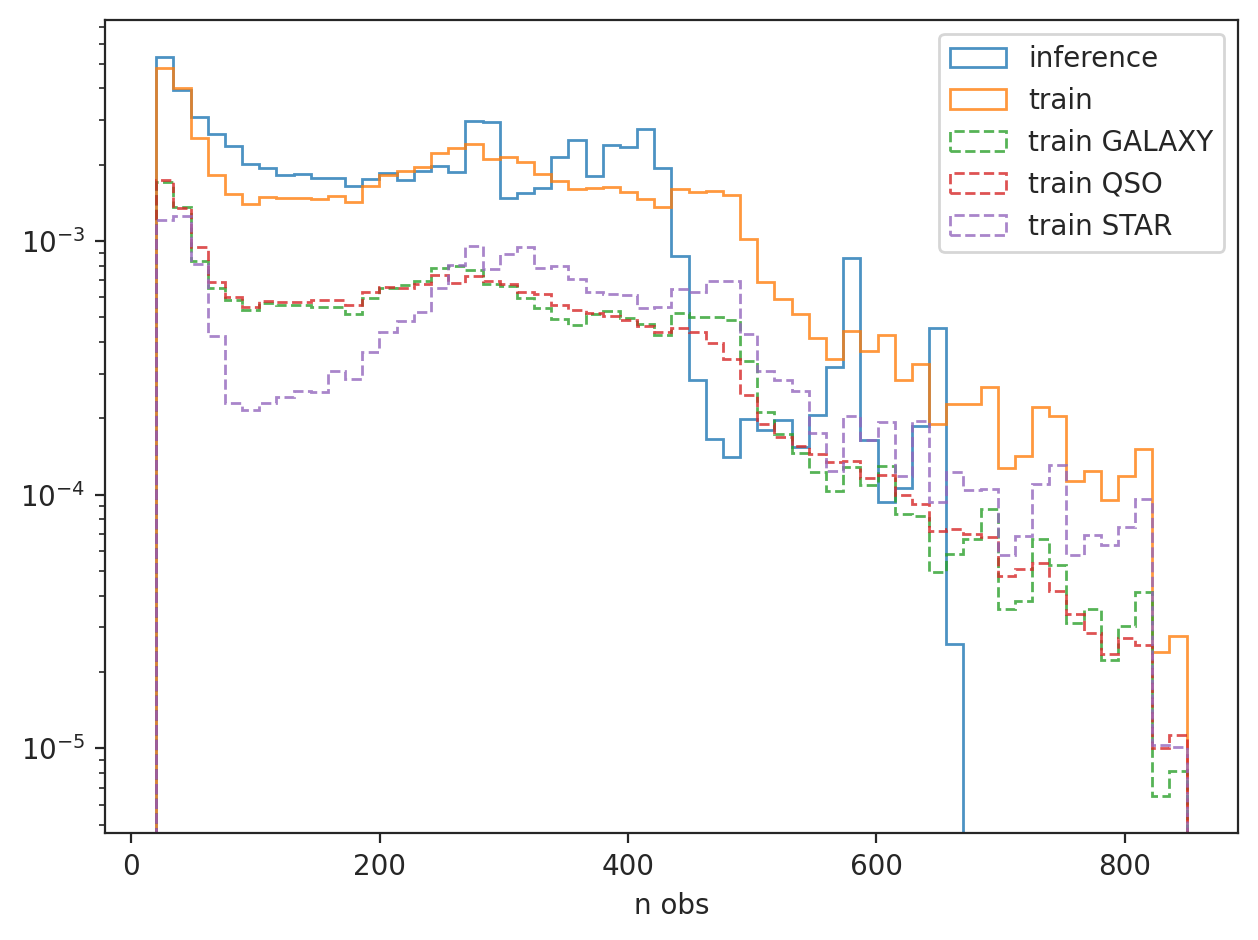

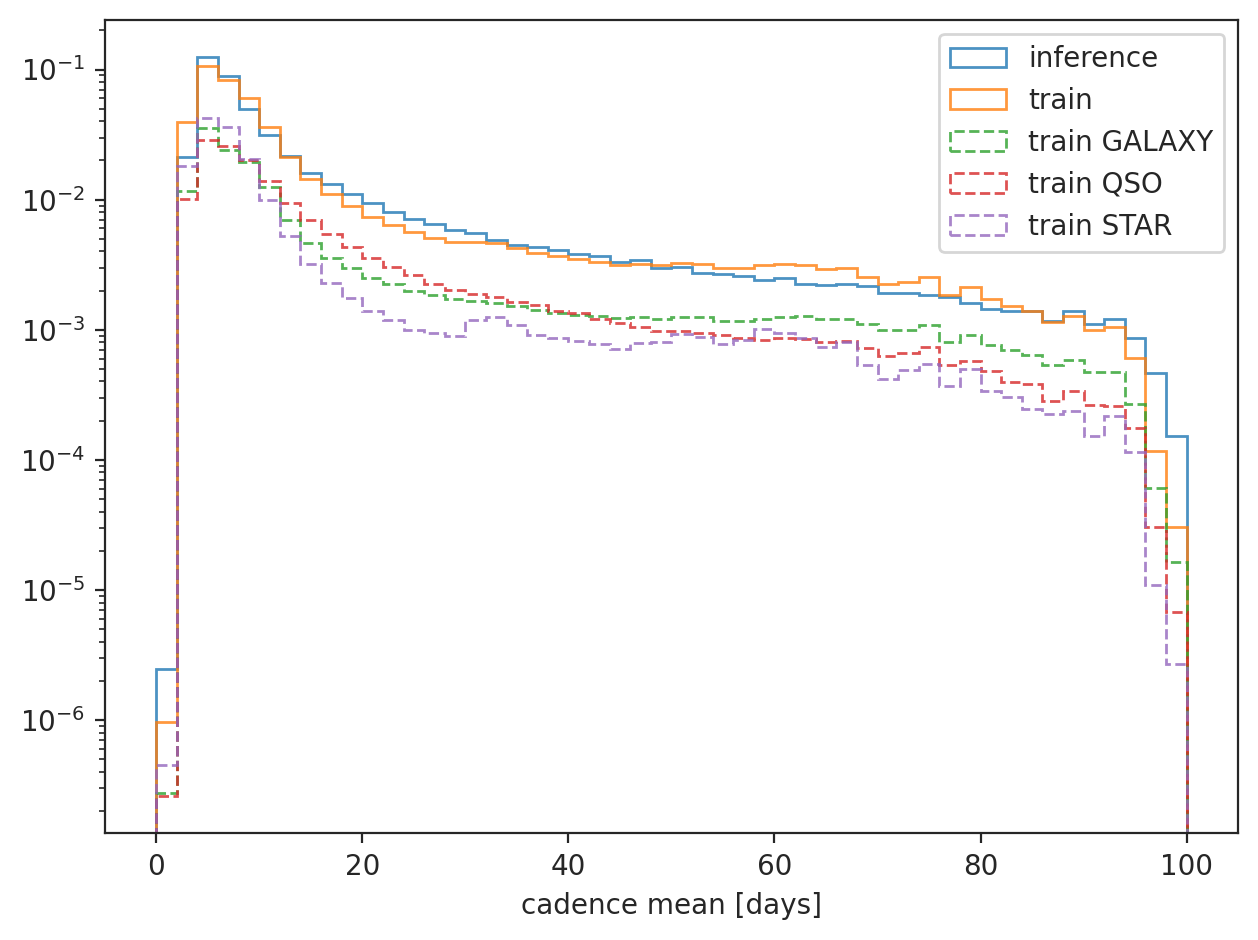

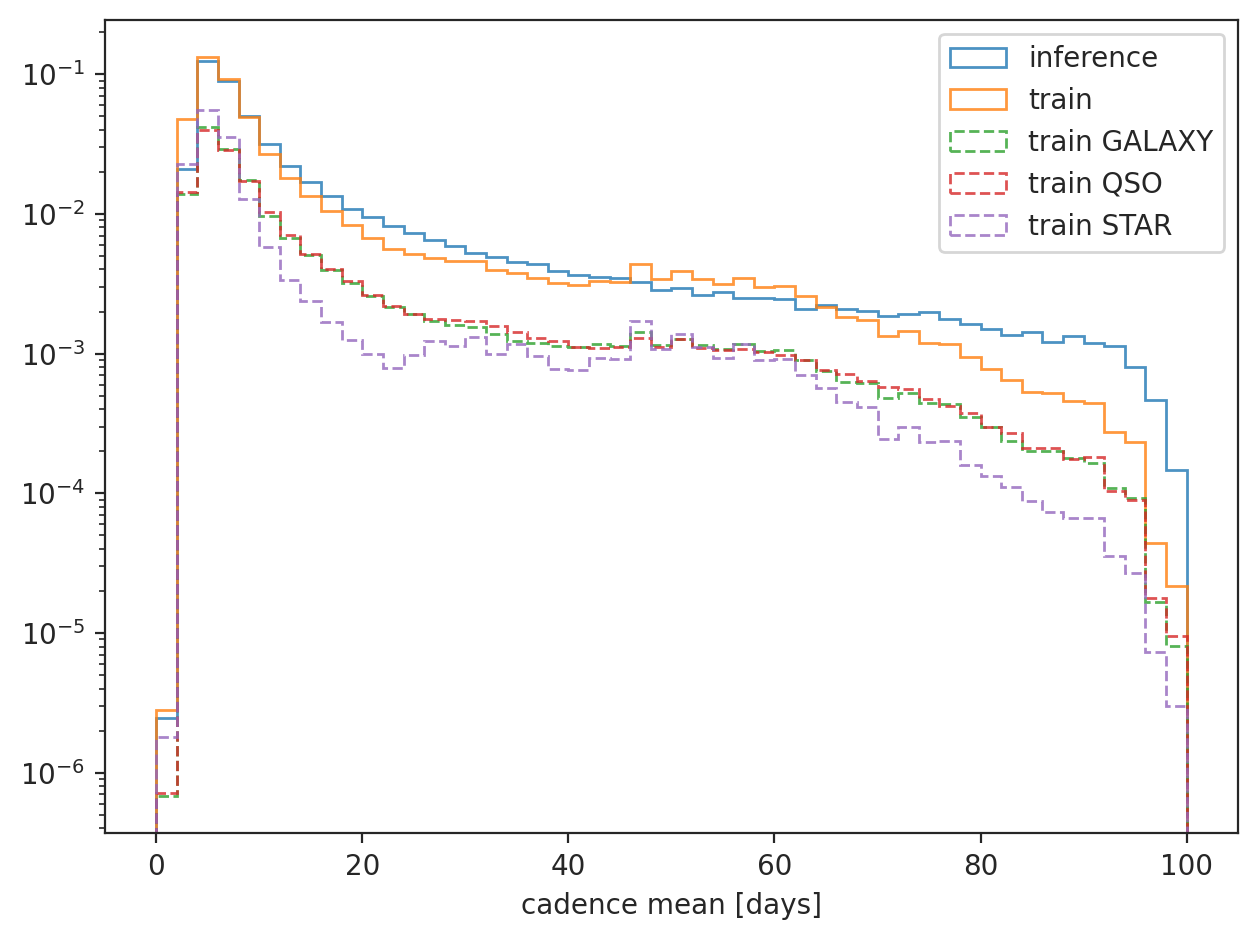

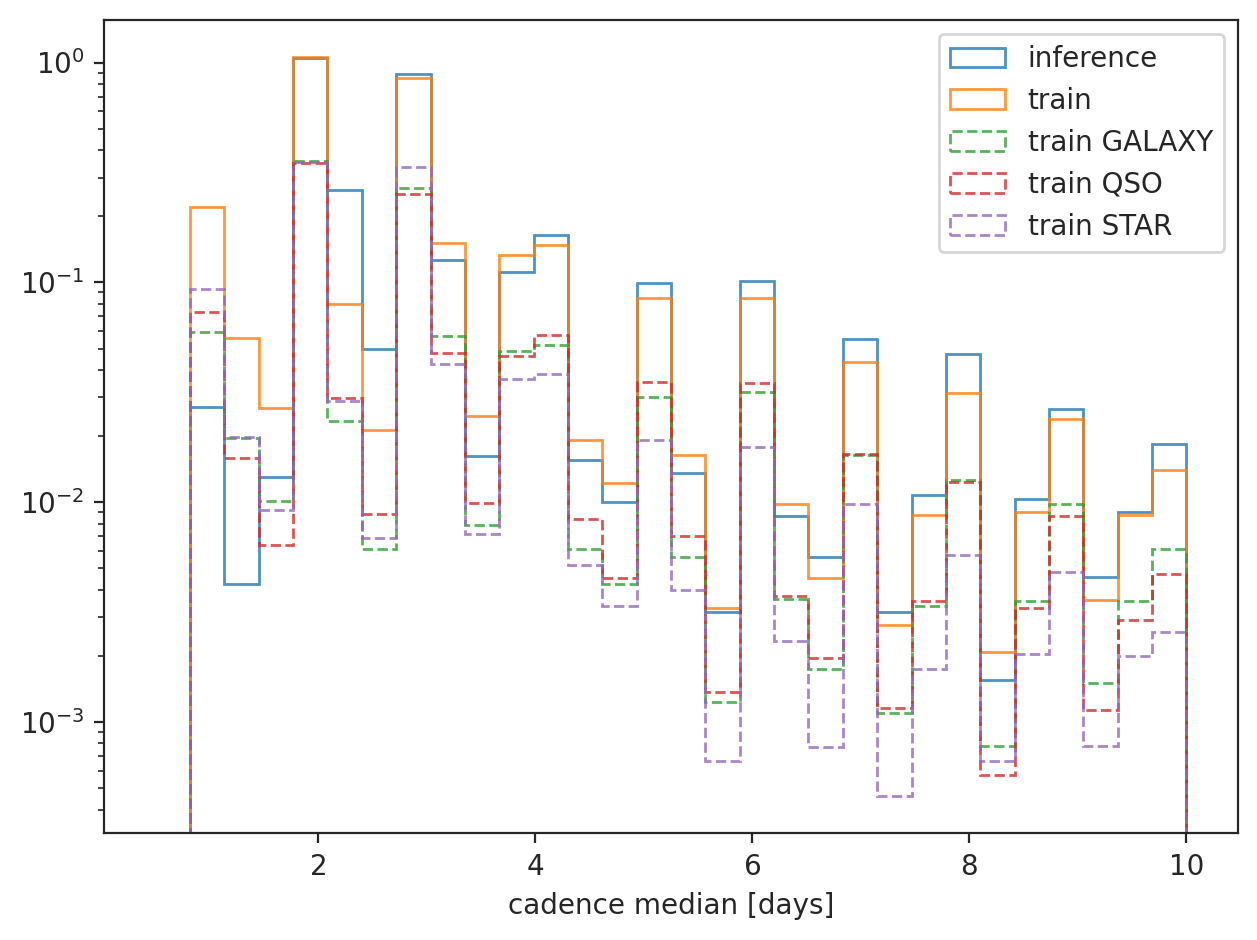

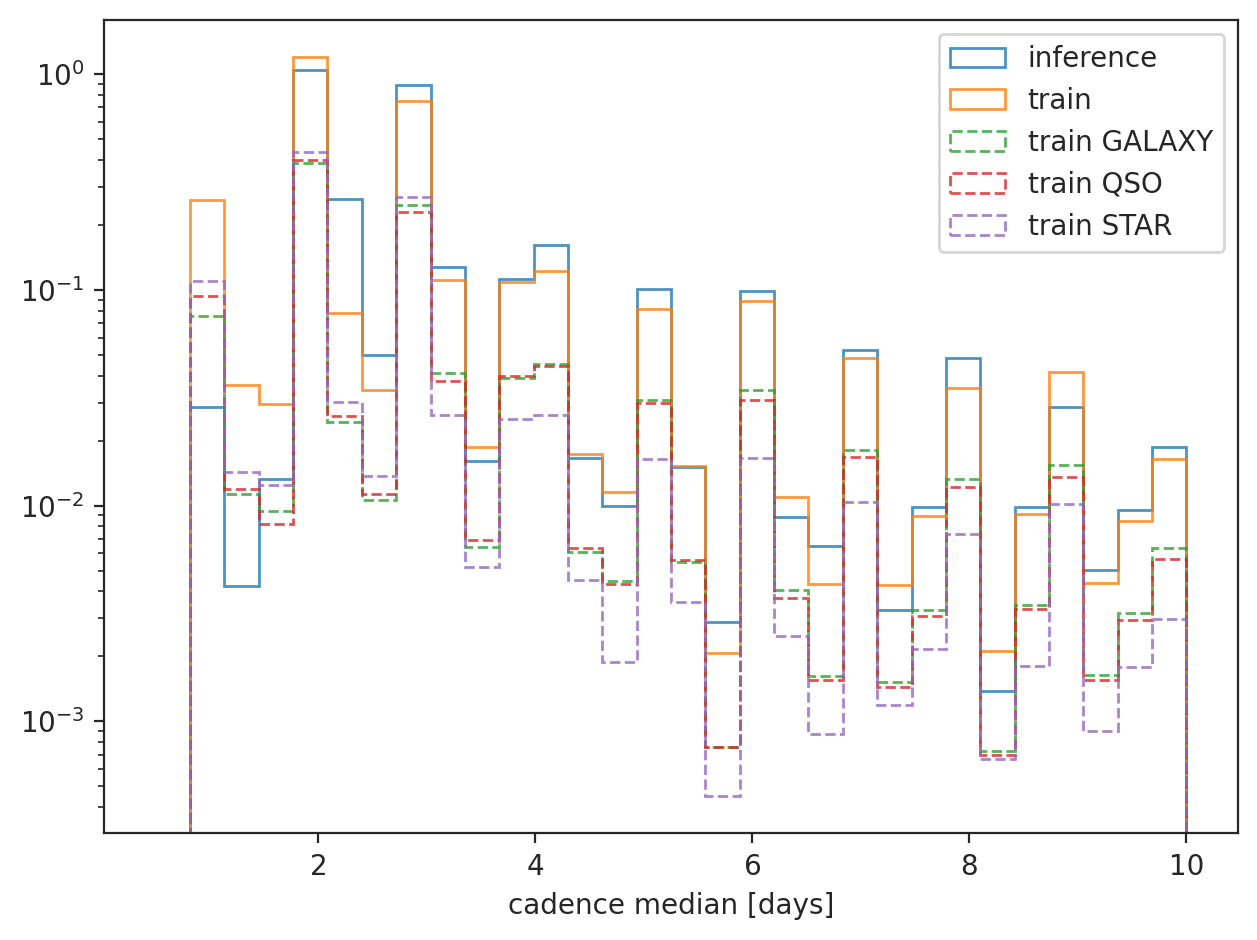

In [9]:
# x label, x range, n bins, log scale
to_plot = [
    ('mag median',      (12, 22.2),    80,  False),
    ('mag err mean',    (0.0, 0.3),    80,  False),
    ('timespan',        (1400, 1950),  30,  True),
    ('n obs',           (20, 850),     60,  True),
    ('cadence mean',    (0, 100),      50,  True),
    ('cadence median',  (0.5, 10),     30,  True),
]

alpha = 0.8

for x, range, n_bins, log_scale in to_plot:    
    for filter in ['g', 'r']:
        plt.figure()
        
        # Inference
        vals_inference = [lc.get(x) for lc in inference_data[filter]]
        plt.hist(vals_inference, label='inference', range=range, bins=n_bins, density=True,
                 histtype='step', log=log_scale, alpha=alpha)

        # Train
        vals_train = [lc.get(x) for lc in ztf_x_sdss_lc[filter]]
        plt.hist(vals_train, label='train', range=range, bins=n_bins, density=True,
                 histtype='step', log=log_scale, alpha=alpha)

        # Classes
        for class_name in ['GALAXY', 'QSO', 'STAR']:
            data_cls = ztf_x_sdss_lc[filter][sdss_x_ztf[filter]['CLASS'] == class_name]
            vals_cls = [lc.get(x) for lc in data_cls]
            
            # Make custom histogram to rescale each class by a factor of 1/3
            counts, bins = np.histogram(vals_cls, range=range, bins=n_bins, density=True)
            weights = 1 / 3 * counts
            plt.hist(bins[:-1], bins, weights=weights, label='train ' + class_name,
                     histtype='step', log=log_scale, alpha=alpha, linestyle='--')

        plt.xlabel(pretty_print(x))
        plt.legend()
        plt.tight_layout()
        plt.show()

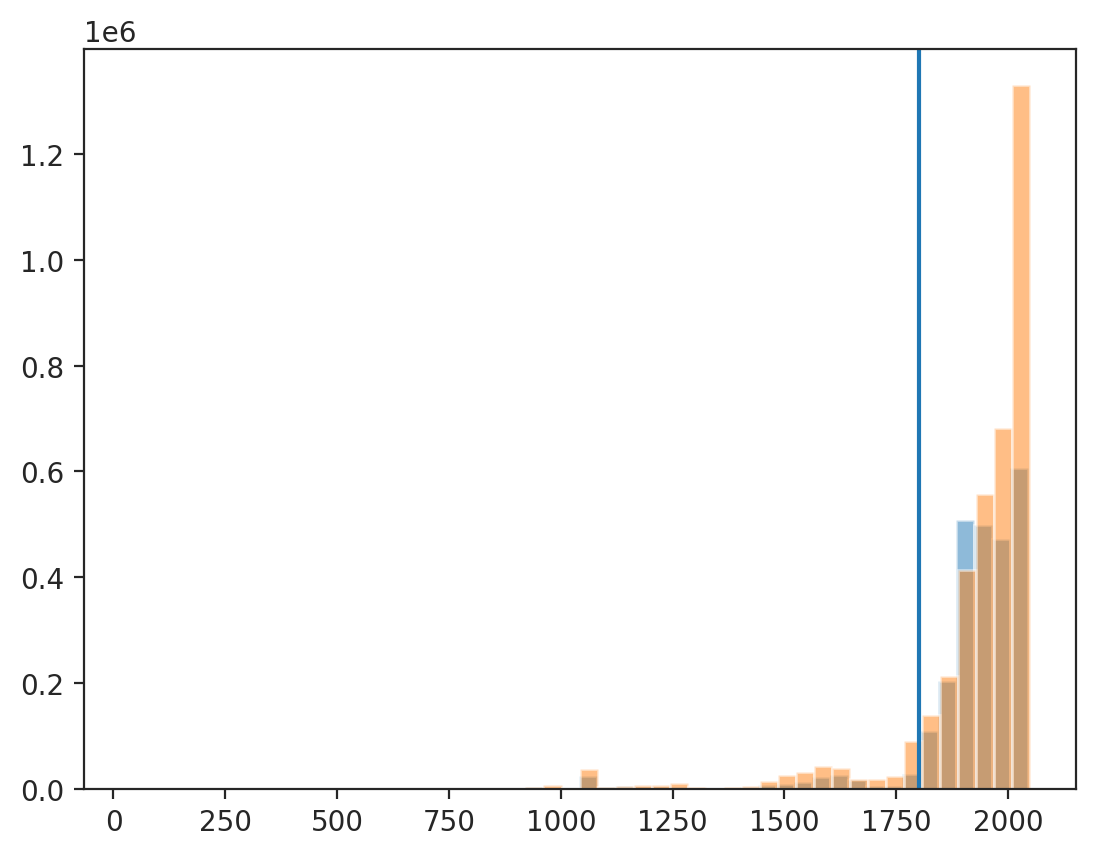

In [10]:
# Histogram of timespan
for filter in ['g', 'r']:
    plt.hist(data[filter]['timespan'], bins=50, alpha=0.5)
plt.axvline(1800)

## Magnitude and number of observation limits

In [12]:
# Histogram of number of observations
n_obs = [lc_dict['n obs'] for lc_dict in ztf_x_sdss_lc['g']]

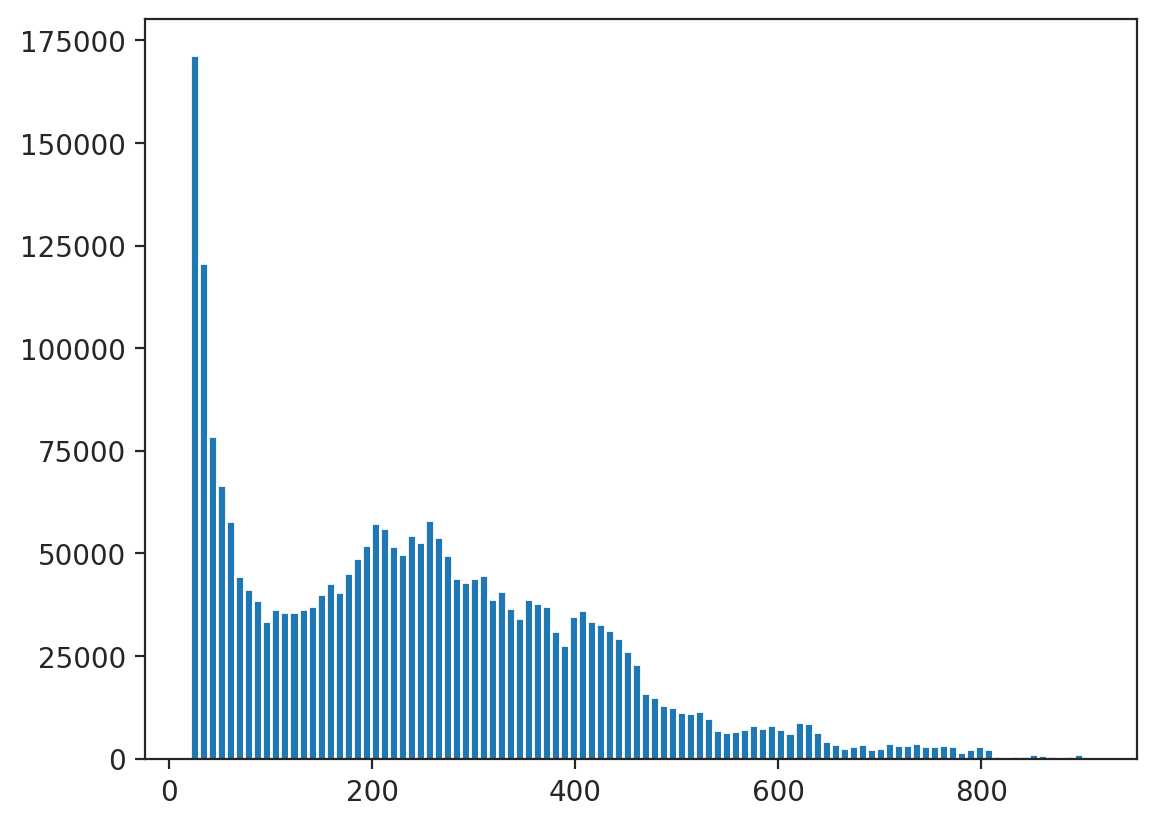

In [15]:
plt.hist(n_obs, cumulative=False, bins=100)
plt.show()

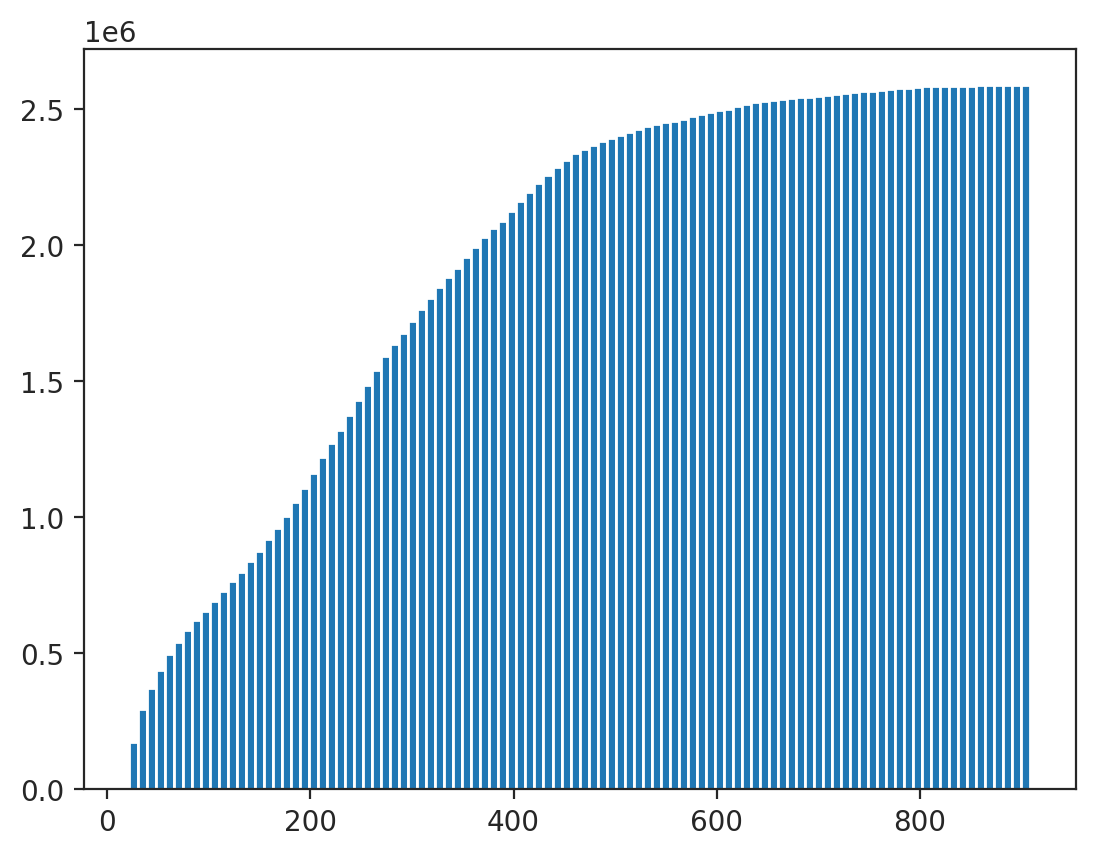

In [14]:
plt.hist(n_obs, cumulative=True, bins=100)
plt.show()

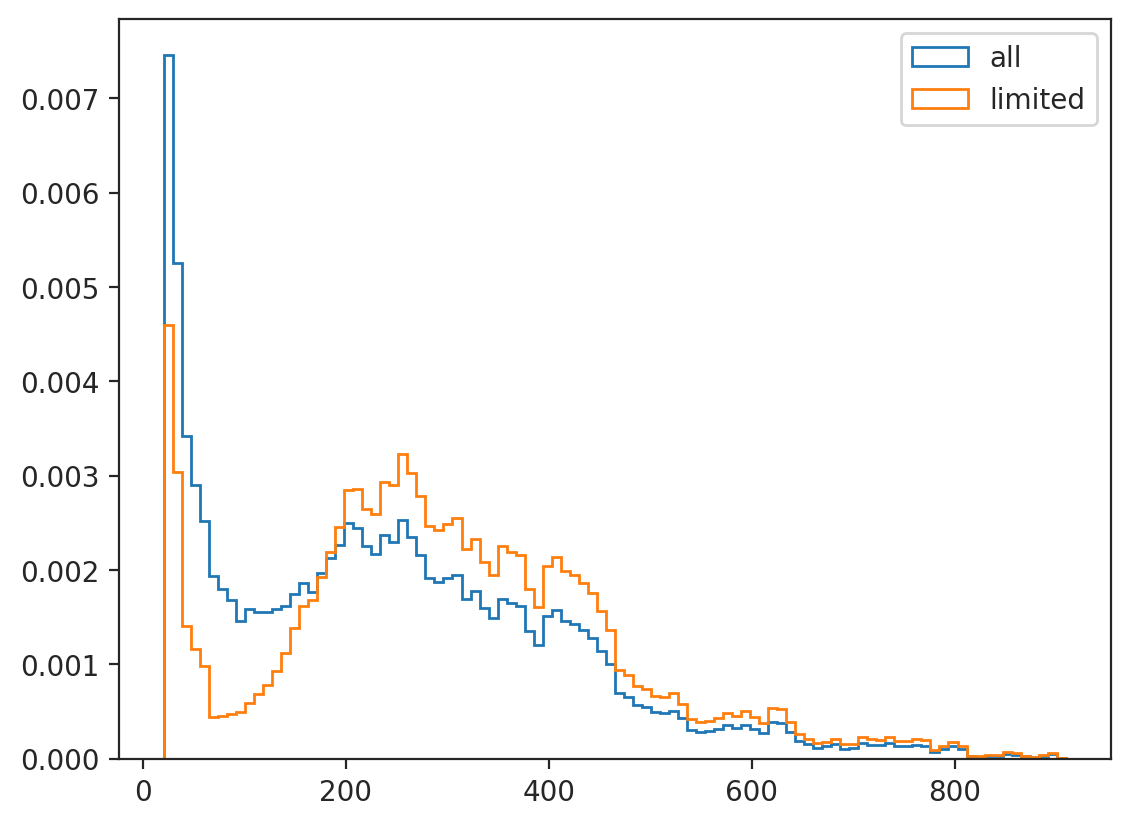

In [119]:
# Check histogram of n_obs for all vs magnitude limit
plt.hist(data['g']['n obs'], bins=100, label='all', density=True, histtype='step')

tmp = data['g'].loc[data['g']['mag median'] < 20.8]
plt.hist(tmp['n obs'], bins=100, label='limited', density=True, histtype='step')

plt.legend()
plt.show()

In [120]:
print('No limit')
counts = np.unique(data['g']['CLASS'], return_counts=True)
for cls, val in zip(counts[0], counts[1]):
    print('{}\t{}\t{:.1f}%'.format(cls, val, val / sum(counts[1]) * 100))

print('\nLimited')
counts = np.unique(tmp['CLASS'], return_counts=True)
for cls, val in zip(counts[0], counts[1]):
    print('{}\t{}\t{:.1f}%'.format(cls, val, val / sum(counts[1]) * 100))

No limit
GALAXY	1204959	46.6%
QSO	645062	24.9%
STAR	738200	28.5%

Limited
GALAXY	852193	46.2%
QSO	364491	19.8%
STAR	628688	34.1%


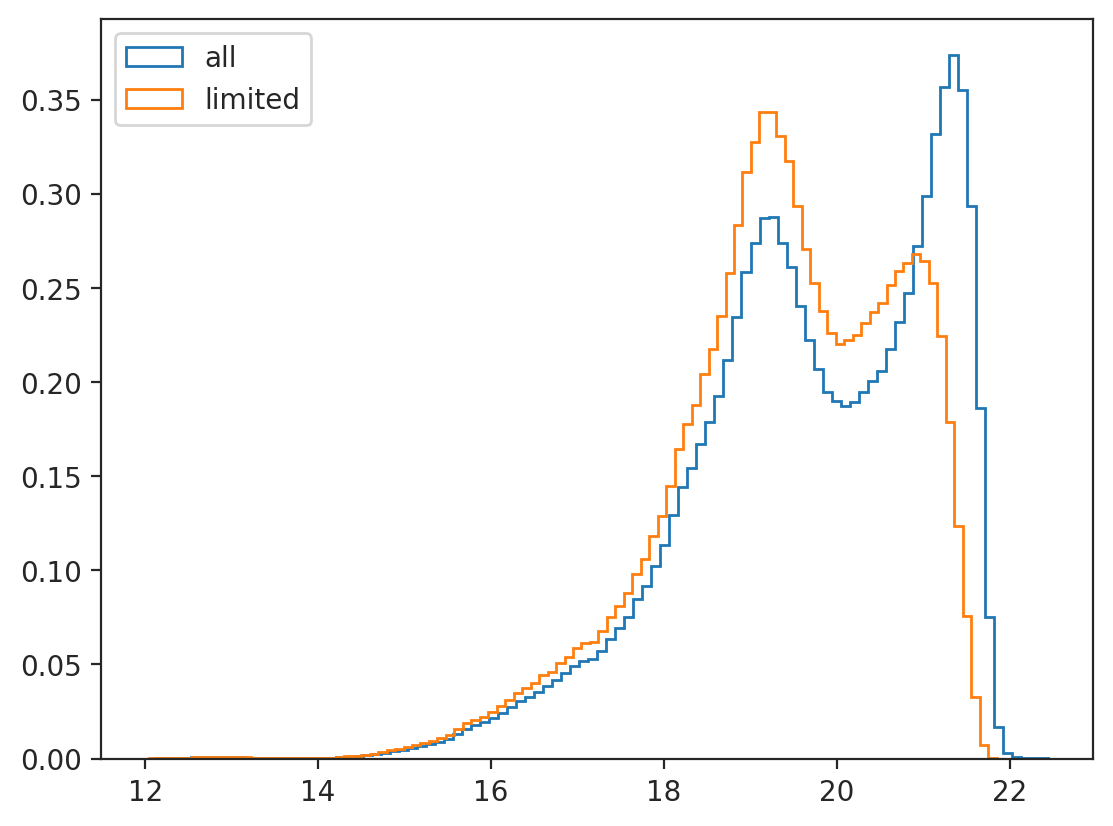

In [31]:
# Check histogram of n_obs for all vs magnitude limit
plt.hist(data['g']['mag median'], bins=100, label='all', density=True, histtype='step')

tmp = data['g'].loc[data['g']['n obs'] >= 100]
plt.hist(tmp['mag median'], bins=100, label='limited', density=True, histtype='step')

plt.legend()
plt.show()

In [32]:
print('No limit')
counts = np.unique(data['g']['CLASS'], return_counts=True)
for cls, val in zip(counts[0], counts[1]):
    print('{}\t{}\t{:.1f}%'.format(cls, val, val / sum(counts[1]) * 100))

print('\nLimited')
counts = np.unique(tmp['CLASS'], return_counts=True)
for cls, val in zip(counts[0], counts[1]):
    print('{}\t{}\t{:.1f}%'.format(cls, val, val / sum(counts[1]) * 100))

No limit
GALAXY	1204959	46.6%
QSO	645062	24.9%
STAR	738200	28.5%

Limited
GALAXY	859379	44.3%
QSO	471240	24.3%
STAR	608318	31.4%


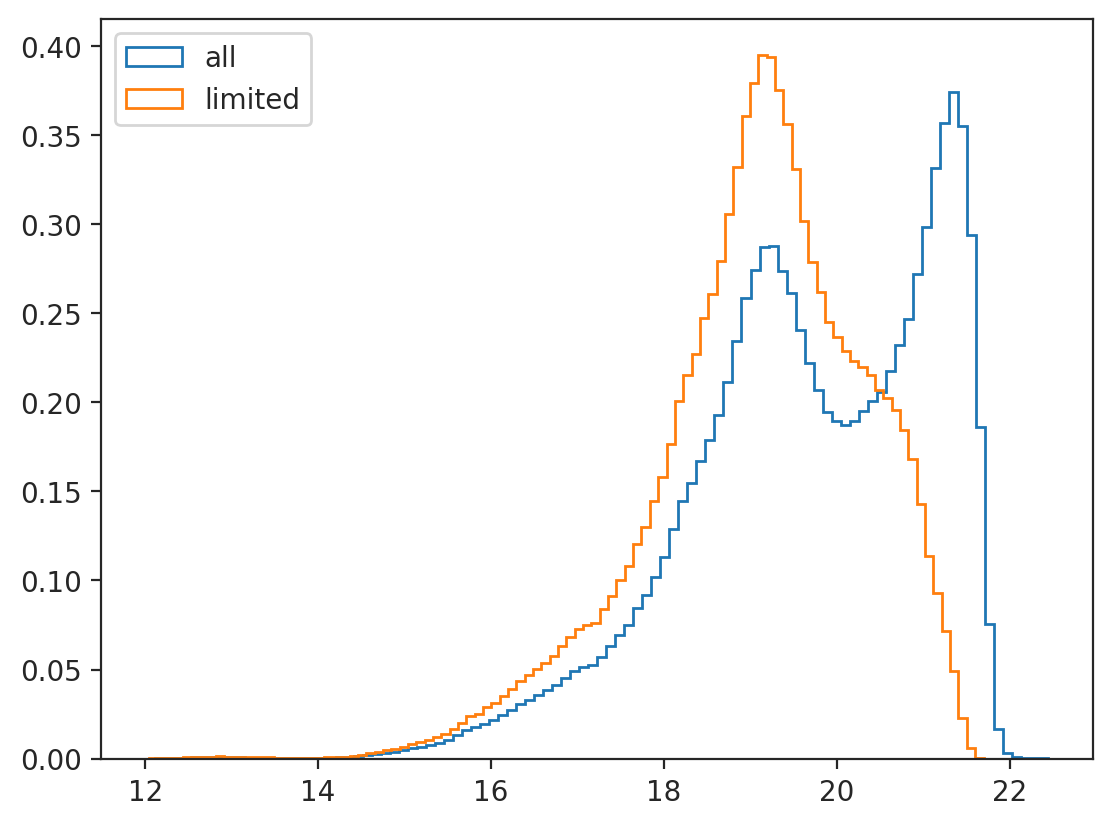

In [124]:
# Check histogram of n_obs for all vs magnitude limit
plt.hist(data['g']['mag median'], bins=100, label='all', density=True, histtype='step')

tmp = data['g'].loc[data['g']['n obs'] >= 200]
plt.hist(tmp['mag median'], bins=100, label='limited', density=True, histtype='step')

plt.legend()
plt.show()

In [122]:
print('No limit')
counts = np.unique(data['g']['CLASS'], return_counts=True)
for cls, val in zip(counts[0], counts[1]):
    print('{}\t{}\t{:.1f}%'.format(cls, val, val / sum(counts[1]) * 100))

print('\nLimited')
counts = np.unique(tmp['CLASS'], return_counts=True)
for cls, val in zip(counts[0], counts[1]):
    print('{}\t{}\t{:.1f}%'.format(cls, val, val / sum(counts[1]) * 100))

No limit
GALAXY	1204959	46.6%
QSO	645062	24.9%
STAR	738200	28.5%

Limited
GALAXY	643460	43.5%
QSO	321490	21.8%
STAR	512791	34.7%


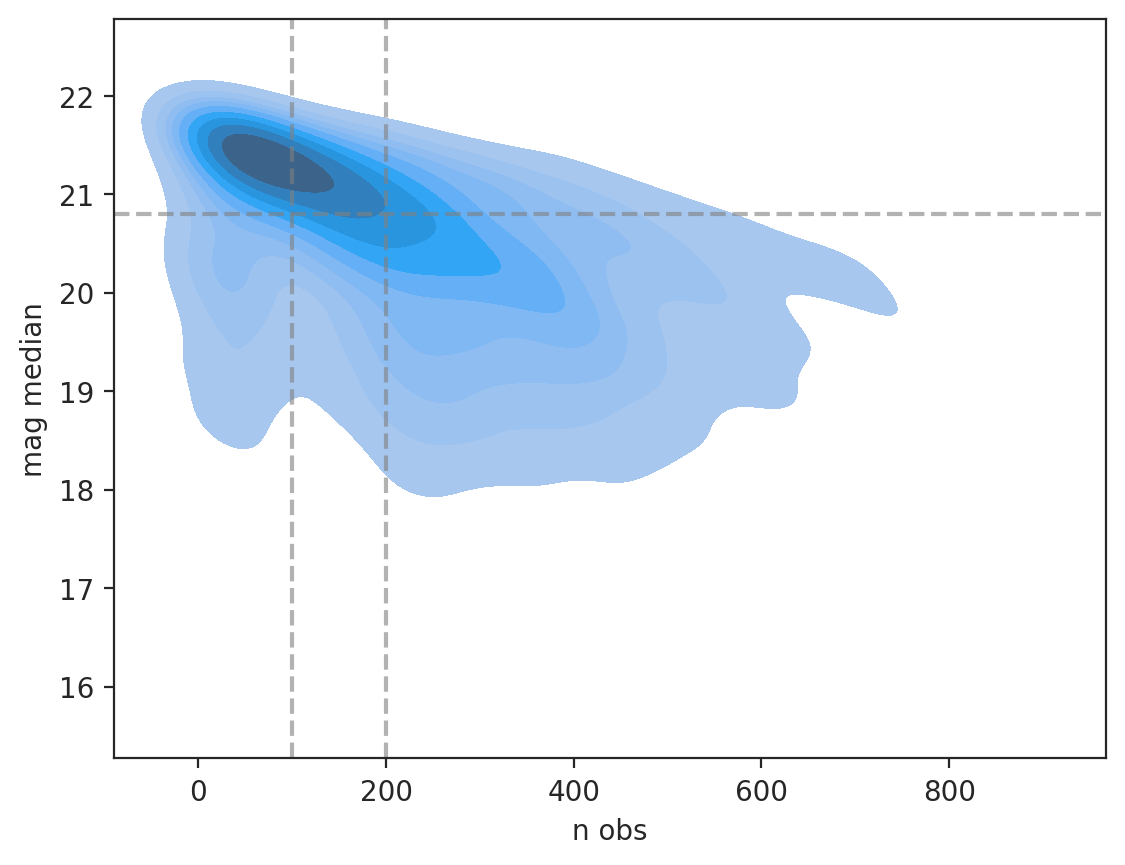

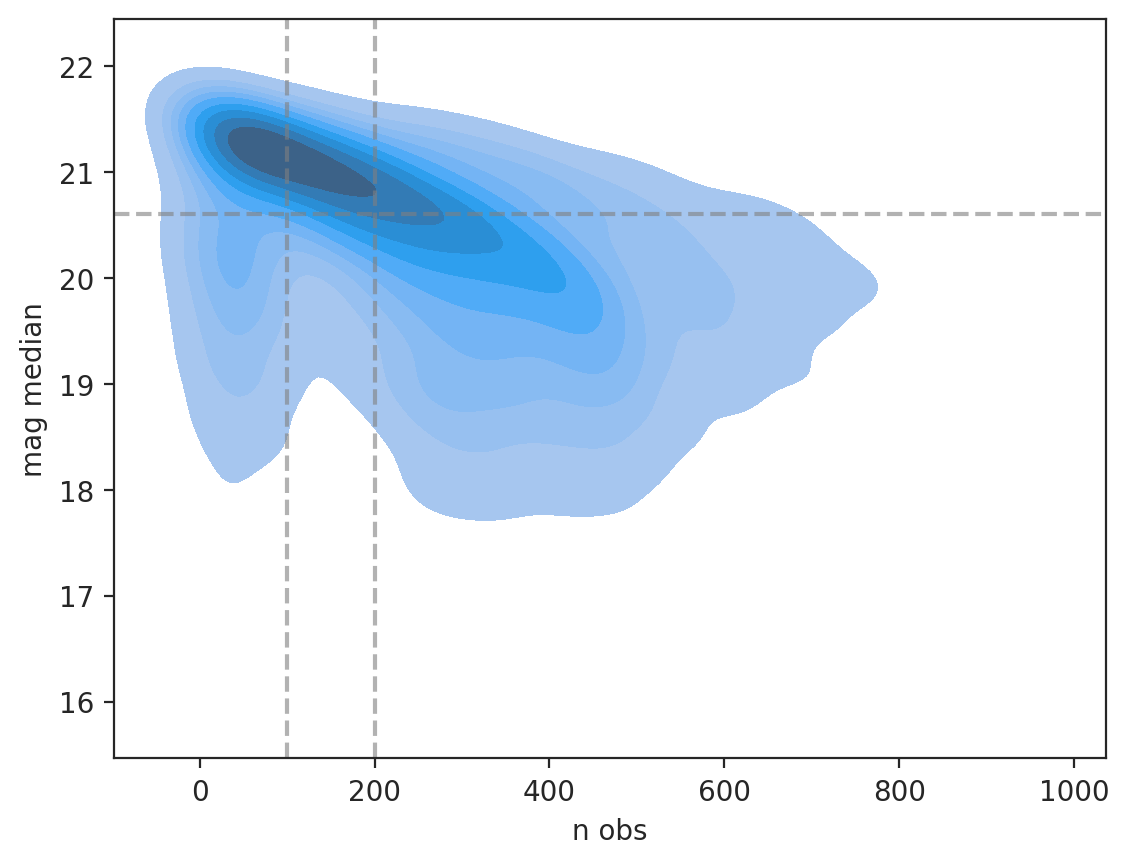

In [21]:
# For quasars, class vs number of obsservations vs magnitude
mag_limits = {
    'g': 20.8,
    'r': 20.6
}
for filter in ['g', 'r']:
    tmp = data[filter].loc[data[filter]['CLASS'] == 'QSO']
    sns.kdeplot(tmp.sample(frac=0.01), x='n obs', y='mag median', fill='True')
    plt.axhline(y=mag_limits[filter], alpha=0.6, color='gray', linestyle='--')
    plt.axvline(x=100, alpha=0.6, color='gray', linestyle='--')
    plt.axvline(x=200, alpha=0.6, color='gray', linestyle='--')
    plt.show()

## Light curves plots

In [1]:
# Pick a subset of QSOs at a high enough number of observations
sdss_x_ztf['g']['n obs'] = n_obs
idx_qso = (sdss_x_ztf['g']['CLASS'] == 'QSO') & (sdss_x_ztf['g']['n obs'] >= 80)

plot_light_curves(ztf_x_sdss_lc['g'][idx_qso], sdss_x_ztf['g'].loc[idx_qso].reset_index(drop=True))

NameError: name 'n_obs' is not defined

# Save train data stats

In [5]:
columns = [
    'mag median', 'mag err mean', 'n obs', 'timespan',
    'cadence mean', 'cadence median', 'cadence plus sigma', 'cadence minus sigma',
]
for filter in ['g', 'r']:
    ztf_x_sdss_lc, _ = get_train_data(ztf_date=ztf_date, filter=filter)    
    ztf_x_sdss_lc = add_lc_stats(ztf_x_sdss_lc)
    stats_df = pd.DataFrame.from_records(ztf_x_sdss_lc, columns=columns)
    
    file_name = 'ZTF_x_SDSS/ZTF_{}/ztf_{}_x_specObj-dr18__longests_filter_{}_reduced__stats'.format(
        ztf_date, ztf_date, filter)
    path = os.path.join(DATA_PATH, file_name)
    with open(path, 'wb') as file:
        pickle.dump(stats_df, file)

Adding light curve statistics:   0%|          | 0/2588221 [00:00<?, ?it/s]

Adding light curve statistics:   0%|          | 0/3750935 [00:00<?, ?it/s]

# ZTF duplicates

In [4]:
import astropy.units as u
from astropy.coordinates import SkyCoord

from utils import read_fits_to_pandas

In [6]:
date = ZTF_DATES['DR 20']
filter_name = 'g'
field = 423

In [7]:
file_name = 'ZTF/ZTF_{}/fields/ZTF_{}__field_{}__{}-band.fits'.format(
    date, date, field, filter_name)
file_path = os.path.join(STORAGE_PATH, file_name)
data = read_fits_to_pandas(file_path)

In [10]:
idx = data['n obs'] > 0

In [11]:
positions = SkyCoord(
    ra=data[idx]['ra'].to_numpy() * u.degree,
    dec=data[idx]['dec'].to_numpy() * u.degree,
)

In [12]:
%%time
idx_1, idx_2, sep_2d, dist_3d = positions.search_around_sky(positions, 1 * u.arcsec)

CPU times: user 1.32 s, sys: 103 ms, total: 1.42 s
Wall time: 1.42 s


# PWG catalogs

In [37]:
catalogs = ['PS1_DR1', 'AllWISE', 'Gaia_EDR3']

## Merge

In [7]:
from astropy.table import Table, vstack

In [38]:
# Read the chunks
data = {}
for catalog in catalogs:
    data[catalog] = []

    # Get input paths sorted
    input_regex = '{}/chunks/{}__*_*.fits'.format(catalog, catalog)
    input_paths = sorted(glob.glob(os.path.join(DATA_PATH, input_regex)))    
    chunk_starts = [int(input_path.split('__')[-1].split('_')[0]) for input_path in input_paths]
    input_paths = [input_path for _, input_path in sorted(zip(chunk_starts, input_paths))]

    print(input_paths[-1])
    
    # Read data
    # for input_path in tqdm(input_paths, catalog):
    #     # data[catalog].append(read_fits_to_pandas(input_path))
    #     data[catalog].append(Table.read(input_path, format='fits'))

/home/sjnakoneczny/data/PS1_DR1/chunks/PS1_DR1__294000000_295000000.fits
/home/sjnakoneczny/data/AllWISE/chunks/AllWISE__295000000_296000000.fits
/home/sjnakoneczny/data/Gaia_EDR3/chunks/Gaia_EDR3__195000000_196000000.fits


In [11]:
a = 294000000

In [31]:
b = 500000

In [32]:
from ztf import CATALOGS_DICT

def get_find_query(catalog, limit, skip, field_id=None, filter=None):
    query = {
        'query_type': 'find',
        'query': {
            'catalog': catalog,
            'filter': {},
            'projection': {
                '_id': 1,
            },
        },
        'kwargs': {
            'max_time_ms': 600000,  # 10 minute
            'limit': limit,
            'skip': skip,
        },
    }
    if catalog[:3] != 'ZTF':
        query['query']['projection'] = CATALOGS_DICT[catalog]
    if field_id is not None:
        query['query']['filter'] = {
            'field': {'$eq': field_id},
            'filter': {'$eq': filter},
        }
    return query

In [33]:
query = get_find_query('PS1_DR1', limit=10000, skip=a+b)

In [34]:
from penquins import Kowalski

from credentials import KOWALSKI_USERNAME, KOWALSKI_PASSWORD

kowalski = Kowalski(
    username=KOWALSKI_USERNAME,
    password=KOWALSKI_PASSWORD,
    host='melman.caltech.edu',
    timeout=99999999,
)

In [35]:
%%time
response = kowalski.query(query=query)

CPU times: user 100 ms, sys: 16.2 ms, total: 117 ms
Wall time: 7min 9s


In [36]:
len(response['default']['data'])

10000

In [ ]:
# TODO: Take the all bands detections only
# TODO: PS griz all?, WISE W1, W2 only?, GAIA all?

In [10]:
# Merge
data_tmp = {}
for catalog in tqdm(catalogs):
    # data_tmp[catalog] = pd.concat(data[catalog])
    data_tmp[catalog] = vstack(data[catalog])

  0%|          | 0/1 [00:00<?, ?it/s]

In [13]:
# Check if all the IDs are unique
print(len(data_tmp[catalogs[0]]))
print(len(np.unique(data_tmp[catalogs[0]]['_id'])))

284000000

In [11]:
# Save
for catalog in tqdm(catalogs):
    file_path = os.path.join(DATA_PATH, '{}/{}.fits'.format(catalog, catalog))
    data_tmp[catalog].write(file_path, overwrite=True)
    print('Saved {}'.format(file_path))

  0%|          | 0/1 [00:00<?, ?it/s]

Saved /home/sjnakoneczny/data/PS1_DR1/PS1_DR1.fits


## Cross-match

In [ ]:
# Read

In [11]:
positions = SkyCoord(
    ra=data[idx]['ra'].to_numpy() * u.degree,
    dec=data[idx]['dec'].to_numpy() * u.degree,
)

In [12]:
%%time
idx_1, idx_2, sep_2d, dist_3d = positions.search_around_sky(positions, 1 * u.arcsec)

CPU times: user 1.32 s, sys: 103 ms, total: 1.42 s
Wall time: 1.42 s


# Fields download

## Progress

In [5]:
filter_name = 'g'

with open(os.path.join(DATA_PATH, 'ZTF/DR19_field_counts.json'), 'r') as file:
    fields = json.load(file)

fields = {x: y for x, y in fields.items() if y != 0} 

is_done = []
for field in fields:
    output_file_name = 'ZTF/ZTF_{}/fields/ZTF_{}__field_{}__{}-band.xz'.format(ztf_date, ztf_date, field, filter_name)
    output_file_name = os.path.join(STORAGE_PATH, output_file_name)
    is_done.append(os.path.exists(output_file_name))

all_fields = len(fields)
done_fields = sum(is_done)
all_ids = sum(fields.values())
done_ids = sum(np.array(list(fields.values()))[np.where(is_done)])

print('Fields\t{} / {}\t\t{:.2f}%'.format(done_fields, all_fields, done_fields / all_fields * 100))
print('Data\t{} / {}\t{:.2f}%'.format(done_ids, all_ids, done_ids / all_ids * 100))

Fields	668 / 1122		59.54%
Data	1309790407 / 2145196883	61.06%


## Check

In [22]:
import sys
import os
import glob
import gc
import random
import argparse

import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
from ASTROMER.models import SingleBandEncoder
from ASTROMER.preprocessing import make_pretraining
from scipy.special import softmax

sys.path.append('..')
from env_config import DATA_PATH, PROJECT_PATH
from light_curves import preprocess_ztf_light_curves
from astromer import build_model
from ztf import ZTF_DATES

In [23]:
filter = 'g'

# Input parameters
date = ZTF_DATES['DR 20']
test_size = 10000

# # Get a list of all the downloaded fields
# input_regex = 'ZTF/ZTF_{}/fields/ZTF_{}__field_*__{}-band'.format(date, date, filter)
# input_paths = sorted(glob.glob(os.path.join(DATA_PATH, input_regex)))

# # Get names of the desired output files
# output_paths = [os.path.join(DATA_PATH, 'ZTF/ZTF_{}/catalog/{}.csv'.format(date, os.path.basename(input_file)))
#                     for input_file in input_paths]

# # Get not processed files
# idx = np.where([not os.path.exists(file) for file in output_paths])[0]
# output_paths = np.array(output_paths)[idx]
# input_paths = np.array(input_paths)[idx]

# Read the model weights
astromer = SingleBandEncoder()
astromer = astromer.from_pretraining('ztfg')
astromer_encoder = astromer.model.get_layer('encoder')
classifier = build_model(astromer_encoder, n_classes=3, maxlen=astromer.maxlen, train_astromer=False)
path_astromer = 'outputs/models/ZTF_{}/ZTF_{}__band_{}__xmatch_ZTF__astromer_FC-1024-512-256'.format(date, date, filter)
classifier.load_weights(os.path.join(PROJECT_PATH, path_astromer))

[INFO] Weights already downloaded


In [ ]:
# TODO: check if IDs in IDs files, and both fits files are the same

In [29]:
stats_file = os.path.join(STORAGE_PATH, 'ZTF/ZTF_{}/fields_progress.txt'.format(ztf_date))
with open(stats_file, 'r') as f:
    print(''.join(f.readlines()))

Field 334 data not present
Field 335	is ok True	IDs 4392365	DF 4392365	data 4392365
Field 336	is ok True	IDs 2060038	DF 2060038	data 2060038
Field 337	is ok True	IDs 1450951	DF 1450951	data 1450951
Field 338	is ok True	IDs 1179041	DF 1179041	data 1179041
Field 339	is ok True	IDs 981755	DF 981755	data 981755
Field 340	is ok True	IDs 886960	DF 886960	data 886960
Field 341	is ok True	IDs 767810	DF 767810	data 767810
Field 342	is ok True	IDs 733544	DF 733544	data 733544
Field 343	is ok True	IDs 755866	DF 755866	data 755866
Field 344	is ok True	IDs 840867	DF 840867	data 840867
Field 345	is ok True	IDs 1017702	DF 1017702	data 1017702
Field 346	is ok True	IDs 982586	DF 982586	data 982586
Field 347	is ok True	IDs 865666	DF 865666	data 865666
Field 348	is ok True	IDs 883114	DF 883114	data 883114
Field 349	is ok True	IDs 1275451	DF 1275451	data 1275451
Field 350	is ok True	IDs 1154102	DF 1154102	data 1154102
Field 351	is ok True	IDs 900270	DF 900270	data 900270
Field 352	is ok True	IDs 956190	DF

In [24]:
fields

{'202': 19565,
 '228': 310213,
 '245': 289199,
 '246': 263089,
 '247': 262224,
 '248': 237820,
 '249': 197109,
 '250': 223755,
 '251': 257763,
 '252': 280328,
 '253': 275188,
 '254': 436648,
 '255': 534590,
 '256': 648251,
 '257': 1065064,
 '258': 1676294,
 '259': 3192070,
 '260': 4500855,
 '261': 4454101,
 '262': 3276532,
 '263': 1369691,
 '264': 846179,
 '265': 582276,
 '266': 494790,
 '267': 454992,
 '268': 436630,
 '269': 408421,
 '270': 407565,
 '271': 514260,
 '272': 547897,
 '273': 787145,
 '274': 901188,
 '275': 965993,
 '276': 1367693,
 '277': 1960129,
 '278': 2161639,
 '279': 6967027,
 '280': 14522900,
 '281': 17944723,
 '282': 17099946,
 '283': 17833284,
 '284': 8517193,
 '285': 3329479,
 '286': 1617230,
 '287': 1093891,
 '288': 878547,
 '289': 728872,
 '290': 422483,
 '291': 351849,
 '292': 312366,
 '293': 318217,
 '294': 421171,
 '295': 434444,
 '296': 409020,
 '297': 407689,
 '298': 353815,
 '299': 400031,
 '300': 431311,
 '301': 424118,
 '302': 470988,
 '303': 525798,
 '

In [25]:
field = 334

data_file_name = 'ZTF/ZTF_{}/fields/ZTF_{}__field_{}__{}-band'.format(
                        ztf_date, ztf_date, field, filter_name)
data_file_name = os.path.join(STORAGE_PATH, data_file_name)

with lzma.open(data_file_name + '.xz', 'rb') as f:
    data = pickle.load(f)

EOFError: Compressed file ended before the end-of-stream marker was reached

In [ ]:
len(data)

In [5]:
for filter_name in ['g', 'r']:

    # Read the train data
    data_subsets = ['ZTF']
    ztf_x_sdss, sdss_x_ztf = \
        get_train_data(ztf_date=ztf_date, filter='g', data_subsets=data_subsets, return_features=False)

    # Change shape to feed a neural network and sample random 200 observations
    data = {'X': {}, 'y': {}}
    data['X']['train'], data['X']['val'], data['X']['test'], data['y']['train'], data['y']['val'], data['y']['test'] = \
        get_train_matrices(ztf_x_sdss, sdss_x_ztf)

    # Save
    path = os.path.join(DATA_PATH, 'ZTF_x_SDSS/ZTF_20240117/matrices/ZTF_{}_filter_g__{}_{}.pickle')
    for data_label in data:
        for split_label in ['train', 'val', 'test']:
            path_formatted = path.format(ztf_date, data_label, split_label)
            print('Saving {}'.format(path_formatted))
            with open(path_formatted, 'wb') as file:
                pickle.dump(data[data_label][split_label], file)

Input matrix:   0%|          | 0/2588221 [00:00<?, ?it/s]


KeyboardInterrupt



# DR 20 vs DR 5 train data

In [4]:
drs = ['DR 5', 'DR 20']
filter = 'g'

In [5]:
ztf_x_sdss, sdss_x_ztf = {}, {}
for dr in drs:
    ztf_x_sdss[dr], sdss_x_ztf[dr] = get_train_data(ztf_date=ZTF_DATES[dr], filter='g', return_features=False)

In [8]:
mags = {}
for dr in drs:
    mags[dr] = [np.mean(lc_dict['mag']) for lc_dict in ztf_x_sdss[dr]]

In [11]:
print(np.max(mags['DR 5']))
print(np.max(mags['DR 20']))

21.84393989071038
22.31891380952381


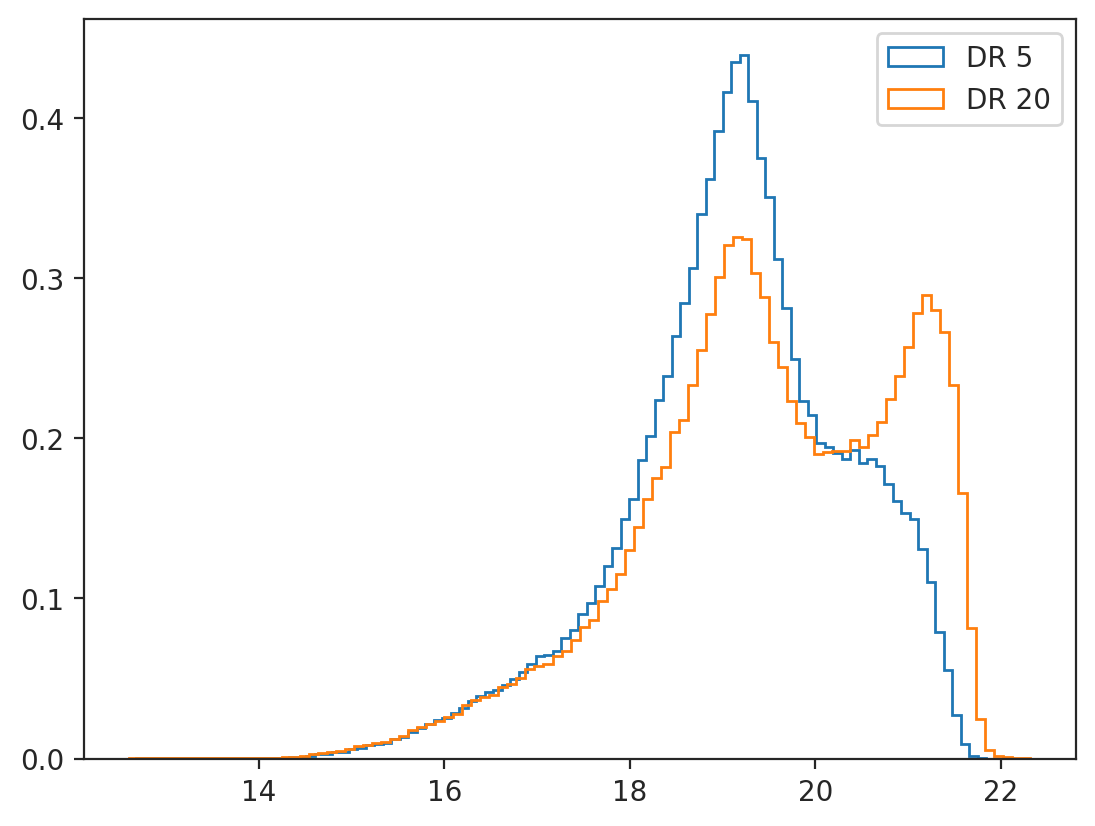

In [14]:
for dr in drs:
    plt.hist(mags[dr], histtype='step', density=True, bins=100, label=dr)
plt.legend()
plt.show()

In [16]:
# This second peak are mostly QSOs
for dr in drs:
    uniques, counts = np.unique(sdss_x_ztf[dr]['CLASS'], return_counts=True)
    percentages = dict(zip(uniques, counts * 100 / len(sdss_x_ztf[dr])))
    print(dr, percentages)

DR 5 {'GALAXY': 53.15958788128799, 'QSO': 18.161101555924457, 'STAR': 28.679310562787556}
DR 20 {'GALAXY': 46.99043747627735, 'QSO': 22.087062635958844, 'STAR': 30.922499887763806}


# Dates

In [22]:
drs = ['DR 5', 'DR 16', 'DR 20']

data = {}
for dr in drs:
    data[dr] = get_train_data(ztf_date=ZTF_DATES[dr], filter='g', return_features=False)[0]

In [26]:
for dr in drs:
    last_date = max([max(lc_dict['mjd']) for lc_dict in data[dr]])
    print('{}: {}, {}'.format(dr, last_date, Time(last_date, format='mjd').to_value('isot')))

DR 5: 59243.22367999982, 2021-01-29T05:22:05.952
DR 16: 60133.4643600001, 2023-07-08T11:08:40.704
DR 20: 60247.40577000007, 2023-10-30T09:44:18.528
